In [33]:
!pip install tensorflow keras

In [34]:
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.graph_objects as go
from keras.utils import plot_model
from keras.models import Sequential
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout

In [35]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/1VNIndex.xlsx' # Đường dẫn đã được cập nhật
df = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [37]:
df.head()


,Price
Date,
2000-07-31,101.55
2000-08-02,103.38
2000-08-04,105.20
2000-08-07,106.92
2000-08-09,108.64


In [38]:
return_series=np.log(df['Price']/df['Price'].shift(1))

In [39]:
return_series = return_series.dropna()

In [40]:
return_series

,Price
Date,
2000-08-02,0.017860
2000-08-04,0.017452
2000-08-07,0.016218
2000-08-09,0.015959
2000-08-11,0.015708
...,...
2024-12-10,-0.001390
2024-12-11,-0.002527
2024-12-12,-0.001191


In [41]:
r_t=return_series.values.reshape(5931,1)

In [42]:
# prompt: đưa ra bảng mô tả thống kê, kurtosis, jacque cho r_t

import pandas as pd
import numpy as np

# Assuming 'return_series' and 'r_t' are defined as in the previous code
# ... (your existing code) ...

# Calculate descriptive statistics
r_t_series = pd.Series(r_t.flatten()) # Convert r_t to a pandas Series for easier calculations
description = r_t_series.describe()

# Calculate kurtosis and skewness (Fisher's definition)
kurtosis = r_t_series.kurtosis()
skewness = r_t_series.skew()


# Print the results
print("Descriptive Statistics:")
print(description)
print("\nKurtosis:", kurtosis)
print("\nSkewness (Fisher):", skewness)

# Create a summary table
summary_table = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    'Value': [description['count'], description['mean'], description['std'], description['min'], description['25%'],
              description['50%'], description['75%'], description['max'], kurtosis, skewness]
})

print("\nSummary Table:")
summary_table

Descriptive Statistics:
count    5931.000000
mean        0.000425
std         0.014439
min        -0.076557
25%        -0.005534
50%         0.000607
75%         0.007378
max         0.066561
dtype: float64

Kurtosis: 3.4097427278606807

Skewness (Fisher): -0.3953987594767815

Summary Table:


,Statistic,Value
0,Count,5931.000000
1,Mean,0.000425
2,Standard Deviation,0.014439
3,Min,-0.076557
4,25%,-0.005534
5,50%,0.000607
6,75%,0.007378
7,Max,0.066561
8,Kurtosis,3.409743
9,Skewness,-0.395399


In [43]:
# prompt: đưa ra kết quả jacque bera test cho r_t

import numpy as np
import pandas as pd
from scipy.stats import jarque_bera

# Assuming 'r_t' is defined as in the previous code
# ... (your existing code) ...

# Perform Jarque-Bera test
jb_statistic, p_value = jarque_bera(r_t.flatten())

print("\nJarque-Bera Test:")
print("Statistic:", jb_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The data does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data may follow a normal distribution.")


Jarque-Bera Test:
Statistic: 3021.0807048199413
p-value: 0.0
Reject the null hypothesis: The data does not follow a normal distribution.


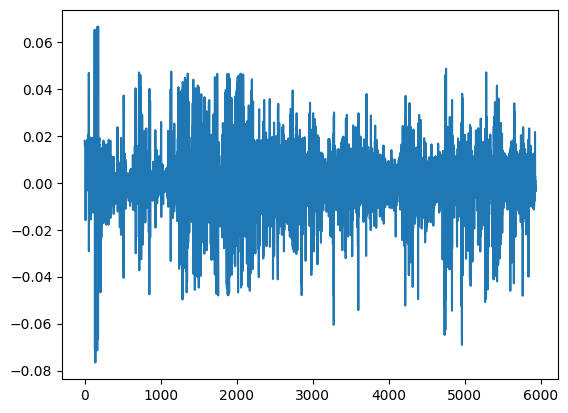

In [44]:
from matplotlib import pyplot as plt
plt.plot(r_t)
plt.show()

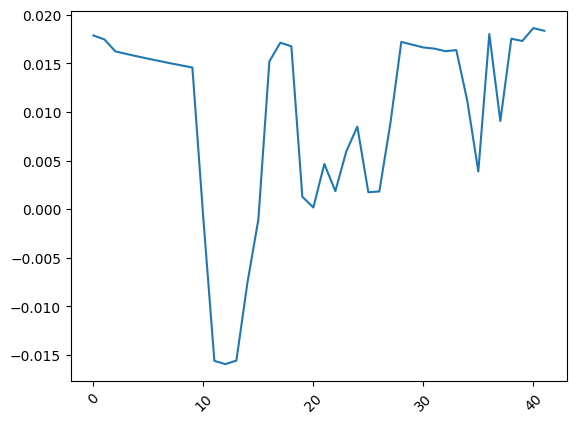

In [45]:
plt.plot(r_t[:42])
plt.xticks(rotation=45)
plt.show()

In [46]:
r_t1 = pd.Series(r_t.flatten())
vol=r_t1.rolling(window=21,min_periods=1).std()
vol1=vol.fillna(vol.mean())
vol2=vol1.values.reshape(5931,1)
vol2

array([[0.01198883],
       [0.00028882],
       [0.00085521],
       ...,
       [0.00766237],
       [0.00722134],
       [0.00667567]])

In [47]:
seq_len = 11
sequence = []
for index in range(len(vol2) - seq_len + 1):
    sequence.append(vol2[index: index + seq_len])
sequence = np.array(sequence)
print(sequence.shape)


(5921, 11, 1)


In [48]:
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.2, shuffle=False,random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False,random_state=42)
    return train_data, val_data, test_data

In [49]:

train_data, val_data, test_data = split_data(sequence)
print("Train:", train_data.shape, "Validation:", val_data.shape, "Test:", test_data.shape)

Train: (4736, 11, 1) Validation: (592, 11, 1) Test: (593, 11, 1)


In [50]:
x_train = train_data[:, :-1, :]
y_train = train_data[:, -1, -1]  # Target (samples,)

x_valid = val_data[:, :-1, :]
y_valid = val_data[:, -1, -1]

x_test = test_data[:, :-1, :]
y_test = test_data[:, -1, -1]

# Kiểm tra kích thước của các tập dữ liệu
print(f"x_train shape: {x_train.shape}")  # (samples, timesteps * features)
print(f"y_train shape: {y_train.shape}")  # (samples,)
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (4736, 10, 1)
y_train shape: (4736,)
x_valid shape: (592, 10, 1)
y_valid shape: (592,)
x_test shape: (593, 10, 1)
y_test shape: (593,)


In [51]:
seq_len2 = 11
sequence2 = []
for index in range(len(r_t) - seq_len + 1):
    sequence2.append(r_t[index: index + seq_len])
sequence2 = np.array(sequence2)
train_data2, val_data2, test_data2 = split_data(sequence2)
x_test2 = test_data[:, :-1, :].reshape(test_data.shape[0], -1)  # Flatten test set
y_test2 = test_data[:, -1, -1]

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [53]:
import math
pi=math.pi
pi

3.141592653589793

In [54]:

def mse_loss(y_true, y_pred):
    # Giả sử y_pred chứa cả giá trị dự đoán (r_t) và độ biến động (sigma_t)
    r_t = tf.cast(y_true, dtype=tf.float32)  # Ép kiểu y_true về tf.float32
    sigma_t = tf.cast(y_pred, dtype=tf.float32) # Độ biến động dự đoán (sigma_t)
    l = tf.cast(tf.shape(r_t)[0], dtype=tf.float32)

    # Tính log-likelihood loss
    loss = (K.sum((r_t-sigma_t)**2))/l
    return loss
def log_likelihood_function(y_true, y_pred):
    r_t = tf.cast(y_true, dtype=tf.float32)  # Ép kiểu y_true về tf.float32
    sigma_t = tf.cast(y_pred, dtype=tf.float32) # Cast y_pred to tf.float32 as well
    # Constants
    import math
    pi=math.pi

    # Calculate log-likelihood using TensorFlow operations
    log_likelihood = K.sum(-0.5*K.log(2*pi) - 2 * K.log(sigma_t) - K.square(r_t) / K.square(sigma_t))

    return log_likelihood

def build_lstm_model(input_length, lstm_units, fc_units, dropout_rate,optimizer):
    model = Sequential()

    # LSTM layer - Set return_sequences=True to output hidden states for all timesteps
    model.add(LSTM(units=lstm_units, input_shape=(input_length, 1), return_sequences=True))

    # Fully connected layer (Dense) - Now receives 3D input from previous LSTM
    model.add(LSTM(fc_units, activation='relu', return_sequences=True)) # Added return_sequences=True here
    model.add(Dropout(dropout_rate))

    # Output layer - output sigma_t (độ biến động dự đoán)
    model.add(LSTM(1, activation='sigmoid'))

    # Biên dịch mô hình với hàm mất mát log-likelihood
    model.compile(optimizer=optimizer, loss=mse_loss)

    return model


In [55]:
import tensorflow as tf
input_length = 10  # Độ dài chuỗi đầu vào
dnn_units = 20    # Số lượng units trong lớp LSTM
fc_units = 40     # Số lượng units trong lớp fully connected
dropout_rate = 0.3 # Tỷ lệ dropout
batch_size = 32  # Kích thước batch
epochs = 500        # Số epoch cho quá trình huấn luyện
optimizer = RMSprop()
# Xây dựng mô hình
model = build_lstm_model(input_length, dnn_units, fc_units, dropout_rate,optimizer)

# Huấn luyện mô hình với dữ liệu generator
history = model.fit(
    x_train,
    y_train,                    # Dữ liệu huấn luyện
    steps_per_epoch=100, # Số bước mỗi epoch
    epochs=epochs,                # Số epoch
    validation_data=(x_valid,y_valid),      # Dữ liệu xác thực
    batch_size=batch_size,
    shuffle= False  # Kích thước batch
    )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - loss: 0.0799 - val_loss: 9.4019e-05
Epoch 2/500
 47/100 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.6428e-05

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.2605e-05 - val_loss: 1.4285e-04
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.1710e-04 - val_loss: 1.2282e-04
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.1648e-05 - val_loss: 1.3343e-04
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 2.2765e-04 - val_loss: 1.0586e-04
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8080e-05 - val_loss: 1.4128e-04
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.1873e-04 - val_loss: 1.0935e-04
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6116e-05 - val_loss: 1.4577e-04
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.0949e-04 - val_loss: 1.0020e-04
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9314e-05 - val_loss: 1.0861e-04
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9214e-04 - val_loss: 1.0903e-04
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

In [56]:
# prompt: đưa ra giá trị loss nhỏ nhất, ở epoch nào

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'history' is the training history object from model.fit
min_loss = np.min(history.history['loss'])
min_loss_epoch = np.argmin(history.history['loss'])

print(f"Minimum loss: {min_loss} at epoch {min_loss_epoch}")


Minimum loss: 2.8401522286003456e-05 at epoch 455


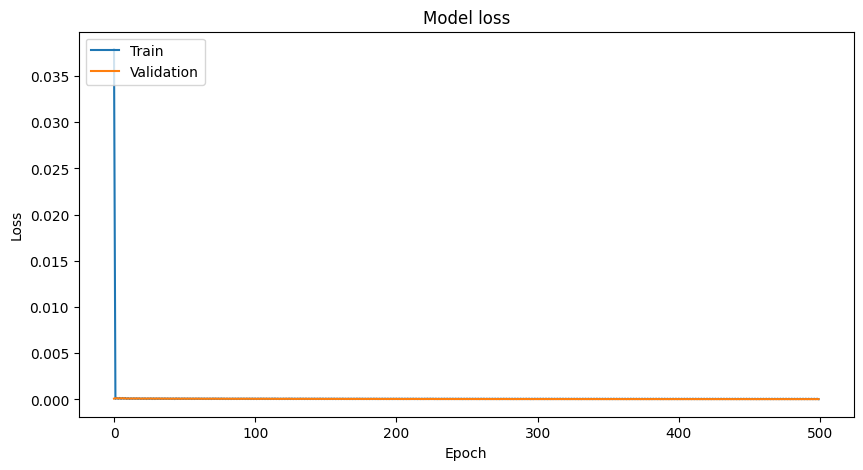

In [57]:
# prompt: vẽ biểu đồ loss

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [58]:
# prompt: đưa ra giá trị dự đoán của mô hình cho test_gen

# Assuming 'model' and 'test_gen' are defined as in the previous code.
# Get predictions for the test data
predictions = model.predict(x_test)

# Print the predictions
predictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


array([[0.00976988],
       [0.00976776],
       [0.00976569],
       [0.00976289],
       [0.00975997],
       [0.00975673],
       [0.009752  ],
       [0.00974776],
       [0.00974168],
       [0.00973517],
       [0.00972906],
       [0.00972649],
       [0.00972424],
       [0.009722  ],
       [0.00972125],
       [0.00972125],
       [0.00972107],
       [0.00972076],
       [0.00972054],
       [0.00972013],
       [0.00971936],
       [0.00971873],
       [0.00971759],
       [0.0097168 ],
       [0.00971682],
       [0.00971771],
       [0.00971901],
       [0.00972107],
       [0.00972274],
       [0.00972659],
       [0.00973096],
       [0.00973599],
       [0.00974162],
       [0.00974338],
       [0.00974537],
       [0.00974697],
       [0.00974906],
       [0.00975146],
       [0.00975444],
       [0.00975816],
       [0.00976183],
       [0.00976451],
       [0.00976719],
       [0.00977094],
       [0.00977562],
       [0.00978174],
       [0.00978736],
       [0.009

In [59]:
predictions.shape


(593, 1)

In [60]:
r_t = tf.cast(y_test2, dtype=tf.float32)  # Ép kiểu y_true về tf.float32
sigma_t = tf.cast(predictions, dtype=tf.float32) # Cast y_pred to tf.float32 as well
# Constants
import math
pi=math.pi

# Calculate log-likelihood
# Use tf.math.log, tf.math.square, and tf.math.reduce_sum
log_L = np.sum(-0.5 * np.log(2 *pi) - np.log(sigma_t) - (r_t**2) / (2 * sigma_t**2))
log_L

1064726.8

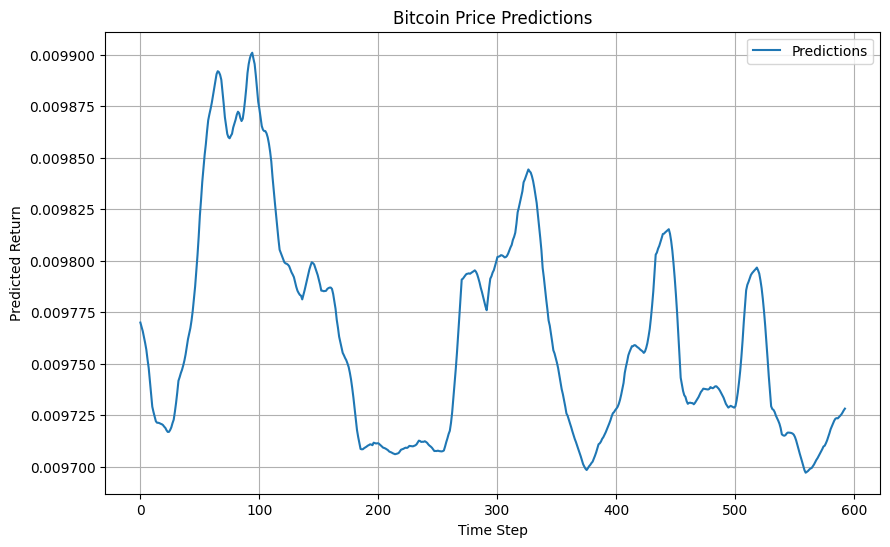

In [61]:
# prompt: vẽ biểu đồ chỉ có predictions

import matplotlib.pyplot as plt

# Assuming 'predictions' is already defined from your model.predict call
# and has the correct shape (number of test samples, 1)

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions')
plt.title('Bitcoin Price Predictions')
plt.ylabel('Predicted Return')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True)
plt.show()